In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_18/3364722086.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [2]:
def load_data():
    # Read data
    data_dir = Path("../input/house-prices-advanced-regression-techniques/")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

In [3]:
data_dir = Path("../input/house-prices-advanced-regression-techniques/")
df = pd.read_csv(data_dir / "train.csv", index_col="Id")

df.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [4]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

In [5]:
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]

five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    for name in features_nom:
        df[name] = df[name].astype("category")
        if "None" not in df[name].cat.categories:
            df[name] = df[name].cat.add_categories("None")
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

In [6]:
"""
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df
"""

'\ndef impute(df):\n    for name in df.select_dtypes("number"):\n        df[name] = df[name].fillna(0)\n    for name in df.select_dtypes("category"):\n        df[name] = df[name].fillna("None")\n    return df\n'

In [7]:
from sklearn.impute import SimpleImputer

def impute(df):
    numeric_columns = df.select_dtypes("number").columns
    numeric_imputer = SimpleImputer(strategy="constant", fill_value=0)
    df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

    categorical_columns = df.select_dtypes("category").columns
    categorical_imputer = SimpleImputer(strategy="constant", fill_value="None")
    df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

    df[categorical_columns] = df[categorical_columns].astype("category")

    return df

In [8]:
df_train, df_test = load_data()

In [9]:
#display(df_train)
#display(df_test)

#display(df_train.info())
#display(df_test.info())

In [10]:
def score_dataset(X, y, model=XGBRegressor()):
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [11]:
from sklearn.metrics import mean_absolute_error

def score_dataset_mae(X, y, model=XGBRegressor()):
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_absolute_error",
    )
    score = -1 * score.mean()
    return score

In [12]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14036 RMSLE


In [13]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [14]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores

OverallQual         0.570843
Neighborhood        0.527157
GrLivArea           0.480792
GarageCars          0.371714
TotalBsmtSF         0.366318
                      ...   
PoolArea            0.000000
Threeseasonporch    0.000000
MoSold              0.000000
YrSold              0.000000
BsmtFinSF2          0.000000
Name: MI Scores, Length: 79, dtype: float64

In [15]:
"""
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

"""

'\ndef drop_uninformative(df, mi_scores):\n    return df.loc[:, mi_scores > 0.0]\n\n'

In [16]:
def drop_uninformative(df, mi_scores):
    columns_to_keep = mi_scores[mi_scores > 0].index.union(['Threeseasonporch'])
    return df[columns_to_keep]

In [17]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score_dataset(X, y)

0.13724634252682824

In [18]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

In [19]:
def mathematical_transforms(df):
    X = pd.DataFrame()
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    return X

def interactions(df):
    X1 = pd.get_dummies(df.BldgType, prefix="Bldg")
    X1 = X1.mul(df.GrLivArea, axis=0)
    X2 = pd.get_dummies(df["BsmtQual"], prefix="BsmtQual")
    X2 = X2.mul(df["TotalBsmtSF"], axis=0)
    X = pd.concat([X1, X2], axis=1)
    return X

def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X


def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X

In [20]:
cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [21]:
def apply_pca(X, standardize=True):
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    pca = PCA()
    X_pca = pca.fit_transform(X)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=component_names,
        index=X.columns,
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    fig.set(figwidth=8, dpi=100)
    return axs

In [22]:
def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

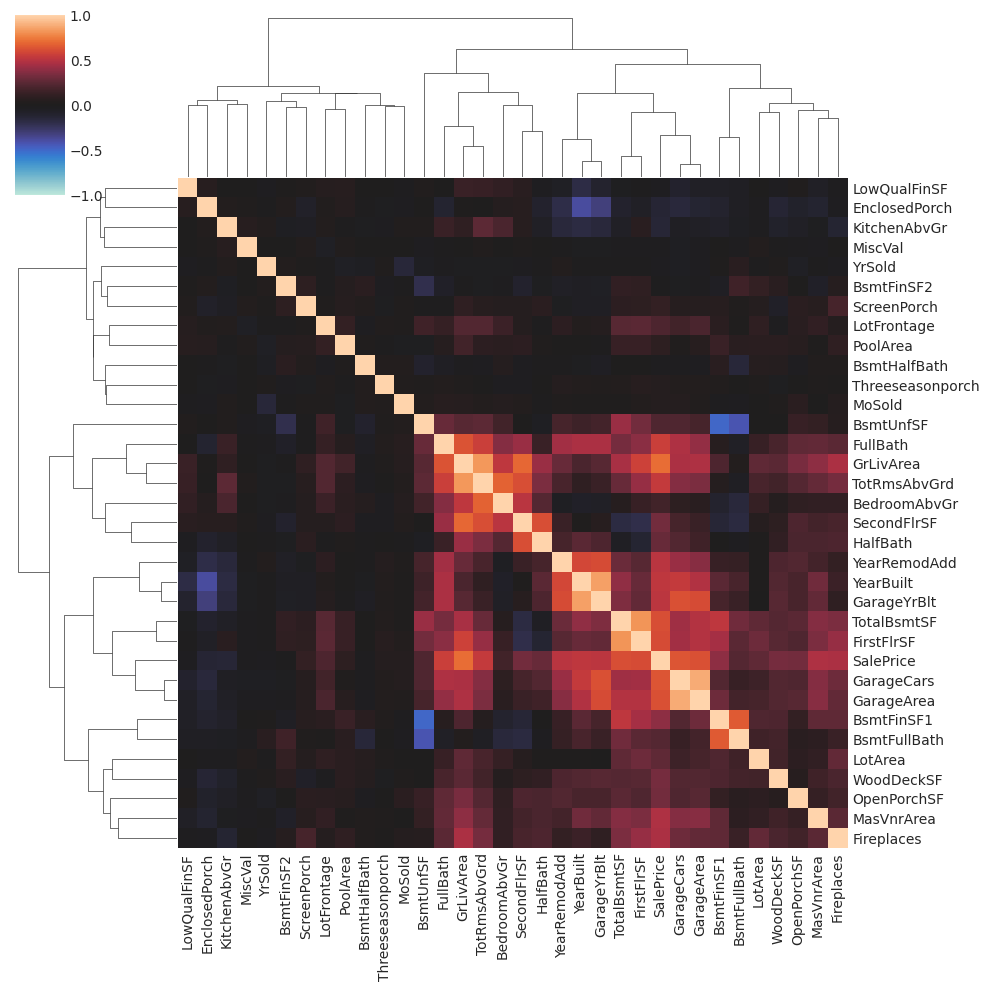

In [23]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method, numeric_only=True),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)

In [24]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new

In [25]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

Use it like:

```
encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
X_encoded = encoder.fit_transform(X, y, cols=["MSSubClass"]))
```

In [26]:
from scipy.stats import skew, boxcox

def handle_skewness(df, skew_threshold=1.0):
    X = df.copy()
    numeric_columns = X.select_dtypes(include=np.number).columns

    for column in numeric_columns:
        skewness = skew(X[column])
        if abs(skewness) > skew_threshold:
            X[column], _ = boxcox(X[column] + 1)

    return X

In [27]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    # Clustering
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # PCA
    X = X.join(pca_inspired(X))
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))
    
    # X = handle_skewness(X)

    X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

0.1381206875877096

In [28]:
from sklearn.ensemble import IsolationForest

def remove_outliers(X, y, contamination=0.01):
    iso_forest = IsolationForest(contamination=contamination, random_state=0)
    outlier_preds = iso_forest.fit_predict(X)

    inlier_indices = outlier_preds == 1
    X_no_outliers = X[inlier_indices]
    y_no_outliers = y[inlier_indices]

    rows_removed = X.shape[0] - X_no_outliers.shape[0]
    print(f"Number of rows removed: {rows_removed}")

    return X_no_outliers, y_no_outliers

In [29]:
X_train_no_outliers, y_train_no_outliers = remove_outliers(X_train, y_train)

score_dataset(X_train_no_outliers, y_train_no_outliers)

# 0.1412036992039651
# 0.1381206875877096
# 0.13481010784770242

Number of rows removed: 15


0.13481010784770242

In [30]:
"""
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, n_jobs=-1)
xgb_params = study.best_params
"""

'\nimport optuna\n\ndef objective(trial):\n    xgb_params = dict(\n        max_depth=trial.suggest_int("max_depth", 2, 10),\n        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),\n        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),\n        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),\n        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),\n        subsample=trial.suggest_float("subsample", 0.2, 1.0),\n        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),\n        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),\n    )\n    xgb = XGBRegressor(**xgb_params)\n    return score_dataset(X_train, y_train, xgb)\n\nstudy = optuna.create_study(direction="minimize")\nstudy.optimize(objective, n_trials=30, n_jobs=-1)\nxgb_params = study.best_params\n'

In [31]:
"""
import optuna

def objective(trial):
    lgb_params = {
        'objective': 'regression',
        'metric': 'rmse',  
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1e2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1e2, log=True),
    }

    lgb_model = lgb.LGBMRegressor(**lgb_params)
    return score_dataset(X_train, y_train, lgb_model)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40, n_jobs=-1)
lgb_params = study.best_params
"""

"\nimport optuna\n\ndef objective(trial):\n    lgb_params = {\n        'objective': 'regression',\n        'metric': 'rmse',  \n        'boosting_type': 'gbdt',\n        'max_depth': trial.suggest_int('max_depth', 2, 10),\n        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),\n        'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),\n        'num_leaves': trial.suggest_int('num_leaves', 2, 256),\n        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),\n        'subsample': trial.suggest_float('subsample', 0.2, 1.0),\n        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),\n        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1e2, log=True),\n        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1e2, log=True),\n    }\n\n    lgb_model = lgb.LGBMRegressor(**lgb_params)\n    return score_dataset(X_train, y_train, lgb_model)\n\nstudy = optuna.create_study(direction='minimize')\nstudy.opti

In [32]:
"""
import optuna

def objective(trial):
    cat_params = {
        'iterations': trial.suggest_int('iterations', 1000, 8000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 1e2, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.2, 1.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
    }

    cat_model = CatBoostRegressor(**cat_params, loss_function='RMSE', silent=True)
    return score_dataset(X_train, y_train, cat_model)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, n_jobs=-1)
cat_params = study.best_params
"""

"\nimport optuna\n\ndef objective(trial):\n    cat_params = {\n        'iterations': trial.suggest_int('iterations', 1000, 8000),\n        'depth': trial.suggest_int('depth', 4, 10),\n        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),\n        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 1e2, log=True),\n        'subsample': trial.suggest_float('subsample', 0.2, 1.0),\n        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.2, 1.0),\n        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),\n    }\n\n    cat_model = CatBoostRegressor(**cat_params, loss_function='RMSE', silent=True)\n    return score_dataset(X_train, y_train, cat_model)\n\nstudy = optuna.create_study(direction='minimize')\nstudy.optimize(objective, n_trials=30, n_jobs=-1)\ncat_params = study.best_params\n"

In [33]:
"""
X_train, X_test = create_features(df_train, df_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)
"""

'\nX_train, X_test = create_features(df_train, df_test)\n\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_test_scaled = scaler.transform(X_test)\n\nX_train_scaled = pd.DataFrame(X_train_scaled)\nX_test_scaled = pd.DataFrame(X_test_scaled)\n'

In [34]:
"""
import optuna
from sklearn.svm import SVR

def objective(trial):
    svr_params = {
        'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
        'tol': trial.suggest_float('tol', 1e-6, 1e-2, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    }

    # 'gamma' parameter handling
    gamma_option = trial.suggest_categorical('gamma_option', ['scale', 'auto', 'value'])
    if gamma_option == 'value':
        svr_params['gamma'] = trial.suggest_float('gamma_val', 1e-3, 1e3, log=True)
    else:
        svr_params['gamma'] = gamma_option

    svr_params['epsilon'] = trial.suggest_float('epsilon', 1e-3, 1e1)

    svr = SVR(**svr_params)
    return score_dataset(X_train_scaled, y_train, svr)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=150, n_jobs=-1)

svr_params = study.best_params
"""

'\nimport optuna\nfrom sklearn.svm import SVR\n\ndef objective(trial):\n    svr_params = {\n        \'C\': trial.suggest_float(\'C\', 1e-3, 1e3, log=True),\n        \'tol\': trial.suggest_float(\'tol\', 1e-6, 1e-2, log=True),\n        \'kernel\': trial.suggest_categorical(\'kernel\', [\'linear\', \'poly\', \'rbf\', \'sigmoid\']),\n    }\n\n    # \'gamma\' parameter handling\n    gamma_option = trial.suggest_categorical(\'gamma_option\', [\'scale\', \'auto\', \'value\'])\n    if gamma_option == \'value\':\n        svr_params[\'gamma\'] = trial.suggest_float(\'gamma_val\', 1e-3, 1e3, log=True)\n    else:\n        svr_params[\'gamma\'] = gamma_option\n\n    svr_params[\'epsilon\'] = trial.suggest_float(\'epsilon\', 1e-3, 1e1)\n\n    svr = SVR(**svr_params)\n    return score_dataset(X_train_scaled, y_train, svr)\n\nstudy = optuna.create_study(direction="minimize")\nstudy.optimize(objective, n_trials=150, n_jobs=-1)\n\nsvr_params = study.best_params\n'

In [35]:
xgb_params_1={
    'max_depth': 5,
    'learning_rate': 0.009811811778973391,
    'n_estimators': 3251,
    'min_child_weight': 8,
    'colsample_bytree': 0.4690587365385624,
    'subsample': 0.31081195048128163,
    'reg_alpha': 0.013627948106852545,
    'reg_lambda': 0.0041131019753380405
} # 0.11981894876282197

xgb_params_2={
    'max_depth': 4, 
    'learning_rate': 0.006131688359853584, 
    'n_estimators': 6190, 
    'min_child_weight': 2, 
    'colsample_bytree': 0.3581743549610146, 
    'subsample': 0.5338565863990985, 
    'reg_alpha': 0.08352484119623702, 
    'reg_lambda': 0.07331349444177808
} # 0.11596275810286498

xgb_params_3={
    'max_depth': 4, 
    'learning_rate': 0.007275762327223734, 
    'n_estimators': 6983, 
    'min_child_weight': 3, 
    'colsample_bytree': 0.3605482622053074, 
    'subsample': 0.5357686047948041, 
    'reg_alpha': 0.0636254887970877, 
    'reg_lambda': 0.07593003104774389
} # 0.11630568020707557

xgb_params_4={
    'max_depth': 4, 
    'learning_rate': 0.005366244438186237, 
    'n_estimators': 6444, 
    'min_child_weight': 2, 
    'colsample_bytree': 0.36518645891787727, 
    'subsample': 0.5197359385165724, 
    'reg_alpha': 0.07349755828526748, 
    'reg_lambda': 0.0629176132955064
} # 0.11628588918288764

xgb_params_5 ={
    'max_depth': 4, 
    'learning_rate': 0.008104469354696579, 
    'n_estimators': 6920, 
    'min_child_weight': 3, 
    'colsample_bytree': 0.5433187101830356, 
    'subsample': 0.5548301950621344, 
    'reg_alpha': 0.07767424218475522, 
    'reg_lambda': 0.0521860849210868
} # 0.11717848187649936

lgb_params_1={
    'max_depth': 4, 
    'learning_rate': 0.0021310684255559523, 
    'n_estimators': 5407, 'num_leaves': 232, 
    'min_child_samples': 1, 
    'subsample': 0.654241325998742, 
    'colsample_bytree': 0.31946876906923594, 
    'reg_alpha': 0.0020187475722182654, 
    'reg_lambda': 0.005983642942367561
} # 0.11766901079356895

lgb_params_2={
    'max_depth': 3, 
    'learning_rate': 0.0023577067509307457, 
    'n_estimators': 6615, 
    'num_leaves': 222, 
    'min_child_samples': 3, 
    'subsample': 0.6877600517982115, 
    'colsample_bytree': 0.22068631570014513, 
    'reg_alpha': 0.001766853153942256, 
    'reg_lambda': 0.020193825712480122
} # 0.11793638007458038

lgb_params_3={
    'max_depth': 3, 
    'learning_rate': 0.002376040462000249, 
    'n_estimators': 7499, 
    'num_leaves': 233, 
    'min_child_samples': 3, 
    'subsample': 0.6483413091168801, 
    'colsample_bytree': 0.30963898272005613, 
    'reg_alpha': 0.0029376559027465186, 
    'reg_lambda': 0.003668791628745425
} # 0.11821324758453972

cat_params_1={
    'iterations': 3850, 
    'depth': 4, 
    'learning_rate': 0.004518075636406027, 
    'l2_leaf_reg': 0.1741669437114363, 
    'subsample': 0.5277491968160333, 
    'colsample_bylevel': 0.46162966224696433, 
    'bagging_temperature': 3.514720095209285
} # 0.11705541579619383

cat_params_2={
    'iterations': 5470, 
    'depth': 5, 
    'learning_rate': 0.0032143813719749314, 
    'l2_leaf_reg': 0.013481045861822716, 
    'subsample': 0.5325670907835423, 
    'colsample_bylevel': 0.4685683864689023, 
    'bagging_temperature': 0.5302149393755751
} # 0.11609408870008495

cat_params_3={
    'iterations': 7510, 
    'depth': 7, 
    'learning_rate': 0.012187754350329648, 
    'l2_leaf_reg': 1.6647298534098425, 
    'subsample': 0.21557070074390394, 
    'colsample_bylevel': 0.4919700393815163, 
    'bagging_temperature': 7.661717088696472
} # 0.11830278177607272

cat_params_4={
    'iterations': 7967, 
    'depth': 4, 
    'learning_rate': 0.005678833174610827, 
    'l2_leaf_reg': 0.0011273910062082509, 
    'subsample': 0.3612127498561881, 
    'colsample_bylevel': 0.7215424952749481, 
    'bagging_temperature': 4.230742958640712
} # 0.11570516174469699

cat_params_5={
    'iterations': 2633, 
    'depth': 4, 
    'learning_rate': 0.04380189764106485, 
    'l2_leaf_reg': 0.002394013286130235, 
    'subsample': 0.2197653771706766, 
    'colsample_bylevel': 0.7625498390819843, 
    'bagging_temperature': 2.2637127205720695
} # 0.11623359281092188

svr_params_1={
    'C': 4.261173128828286,
    'tol': 0.004238177798590693,
    'kernel': 'rbf',
    'gamma_option': 'value',
    'gamma_val': 0.0016666756337017465,
    'epsilon': 0.002735356336222826
} # 0.12322817414445354

svr_params_2={
    'C': 8.082219065252241, 
    'tol': 0.0023987760084588855, 
    'kernel': 'rbf', 
    'gamma_option': 'value', 
    'gamma_val': 0.0010921372030843438, 
    'epsilon': 0.005121382962734013
} # 0.123664157129358

In [36]:
"""
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

cat = XGBRegressor(**xgb_params_1)
score_dataset(X_train, y_train, cat)
"""

'\nX_train, X_test = create_features(df_train, df_test)\ny_train = df_train.loc[:, "SalePrice"]\n\ncat = XGBRegressor(**xgb_params_1)\nscore_dataset(X_train, y_train, cat)\n'

In [37]:
"""
from sklearn.ensemble import VotingRegressor

X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

X_train_no_outliers, y_train_no_outliers = remove_outliers(X_train, y_train)

ensemble_model = VotingRegressor([
    ('stacking_model_1', XGBRegressor(**xgb_params_1)), 
    ('stacking_model_2', XGBRegressor(**xgb_params_2)),
    ('stacking_model_3', XGBRegressor(**xgb_params_3)),
    ('stacking_model_4', XGBRegressor(**xgb_params_4)),
    ('stacking_model_5', XGBRegressor(**xgb_params_5)),
    ('stacking_model_6', lgb.LGBMRegressor(**lgb_params_1)), 
    ('stacking_model_7', lgb.LGBMRegressor(**lgb_params_2)),
    ('stacking_model_8', lgb.LGBMRegressor(**lgb_params_3)),
    ('stacking_model_9', CatBoostRegressor(**cat_params_1, loss_function='RMSE', silent=True)),
    ('stacking_model_10', CatBoostRegressor(**cat_params_2, loss_function='RMSE', silent=True)),
    ('stacking_model_11', CatBoostRegressor(**cat_params_3, loss_function='RMSE', silent=True)), 
    ('stacking_model_12', CatBoostRegressor(**cat_params_4, loss_function='RMSE', silent=True)),
    ('stacking_model_13', CatBoostRegressor(**cat_params_5, loss_function='RMSE', silent=True)),
], n_jobs=-1)
score_dataset(X_train_no_outliers, y_train_no_outliers, ensemble_model)
"""

'\nfrom sklearn.ensemble import VotingRegressor\n\nX_train, X_test = create_features(df_train, df_test)\ny_train = df_train.loc[:, "SalePrice"]\n\nX_train_no_outliers, y_train_no_outliers = remove_outliers(X_train, y_train)\n\nensemble_model = VotingRegressor([\n    (\'stacking_model_1\', XGBRegressor(**xgb_params_1)), \n    (\'stacking_model_2\', XGBRegressor(**xgb_params_2)),\n    (\'stacking_model_3\', XGBRegressor(**xgb_params_3)),\n    (\'stacking_model_4\', XGBRegressor(**xgb_params_4)),\n    (\'stacking_model_5\', XGBRegressor(**xgb_params_5)),\n    (\'stacking_model_6\', lgb.LGBMRegressor(**lgb_params_1)), \n    (\'stacking_model_7\', lgb.LGBMRegressor(**lgb_params_2)),\n    (\'stacking_model_8\', lgb.LGBMRegressor(**lgb_params_3)),\n    (\'stacking_model_9\', CatBoostRegressor(**cat_params_1, loss_function=\'RMSE\', silent=True)),\n    (\'stacking_model_10\', CatBoostRegressor(**cat_params_2, loss_function=\'RMSE\', silent=True)),\n    (\'stacking_model_11\', CatBoostRegressor

In [38]:
"""
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor

base_models = [
    ('stacking_model_1', XGBRegressor(**xgb_params_1)), 
    ('stacking_model_2', XGBRegressor(**xgb_params_2)),
    ('stacking_model_3', XGBRegressor(**xgb_params_3)),
    ('stacking_model_4', XGBRegressor(**xgb_params_4)),
    ('stacking_model_5', XGBRegressor(**xgb_params_5)),
    ('stacking_model_6', lgb.LGBMRegressor(**lgb_params_1)), 
    ('stacking_model_7', lgb.LGBMRegressor(**lgb_params_2)),
    ('stacking_model_8', lgb.LGBMRegressor(**lgb_params_3)),
    ('stacking_model_9', CatBoostRegressor(**cat_params_1, loss_function='RMSE', silent=True)),
    ('stacking_model_10', CatBoostRegressor(**cat_params_2, loss_function='RMSE', silent=True)),
    ('stacking_model_11', CatBoostRegressor(**cat_params_3, loss_function='RMSE', silent=True)), 
    ('stacking_model_12', CatBoostRegressor(**cat_params_4, loss_function='RMSE', silent=True)),
    ('stacking_model_13', CatBoostRegressor(**cat_params_5, loss_function='RMSE', silent=True)),
]

meta_model = GradientBoostingRegressor()

ensemble_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model
)

X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train, ensemble_model)
"""

'\nfrom sklearn.ensemble import StackingRegressor\nfrom sklearn.ensemble import GradientBoostingRegressor\n\nbase_models = [\n    (\'stacking_model_1\', XGBRegressor(**xgb_params_1)), \n    (\'stacking_model_2\', XGBRegressor(**xgb_params_2)),\n    (\'stacking_model_3\', XGBRegressor(**xgb_params_3)),\n    (\'stacking_model_4\', XGBRegressor(**xgb_params_4)),\n    (\'stacking_model_5\', XGBRegressor(**xgb_params_5)),\n    (\'stacking_model_6\', lgb.LGBMRegressor(**lgb_params_1)), \n    (\'stacking_model_7\', lgb.LGBMRegressor(**lgb_params_2)),\n    (\'stacking_model_8\', lgb.LGBMRegressor(**lgb_params_3)),\n    (\'stacking_model_9\', CatBoostRegressor(**cat_params_1, loss_function=\'RMSE\', silent=True)),\n    (\'stacking_model_10\', CatBoostRegressor(**cat_params_2, loss_function=\'RMSE\', silent=True)),\n    (\'stacking_model_11\', CatBoostRegressor(**cat_params_3, loss_function=\'RMSE\', silent=True)), \n    (\'stacking_model_12\', CatBoostRegressor(**cat_params_4, loss_function=\'R

In [39]:
"""
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
ensemble_model.fit(X_train, np.log(y))
predictions = np.exp(ensemble_model.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")
"""

'\n# XGB minimizes MSE, but competition loss is RMSLE\n# So, we need to log-transform y to train and exp-transform the predictions\nensemble_model.fit(X_train, np.log(y))\npredictions = np.exp(ensemble_model.predict(X_test))\n\noutput = pd.DataFrame({\'Id\': X_test.index, \'SalePrice\': predictions})\noutput.to_csv(\'my_submission.csv\', index=False)\nprint("Your submission was successfully saved!")\n'

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*